In [1]:
import pandas as pd
import geopandas as gpd
import pysal.lib as lp
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
import contextily as ctx
import shapely.geometry as geom
%matplotlib inline
import itertools
import gdal
import os
from rasterio.plot import show
from PIL import Image
import glob
import re
from natsort import natsorted

In [2]:
#read in data
storm = pd.read_csv("C:/Users/Administrator/Desktop/788p/Natalie_project/Data/storm_data.csv")
storm

,# ---------------------------------- WARNING ----------------------------------------,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,# Some of the data that you have obtained from...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,# may not have received Director's approval. A...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,# as provisional and are subject to revision. ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,# condition that neither the USGS nor the Unit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,# for any damages resulting from its use.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
312,USGS,4230380,10/5/2021 22:45,EST,109,P,4.05,P,0,P
313,USGS,4230380,10/5/2021 23:00,EST,107,P,4.04,P,0,P
314,USGS,4230380,10/5/2021 23:15,EST,107,P,4.04,P,0,P
315,USGS,4230380,10/5/2021 23:30,EST,105,P,4.03,P,0,P


In [3]:
#Format data
storm.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,28],axis=0,inplace=True)


In [4]:
storm.drop(['Unnamed: 5','Unnamed: 3','Unnamed: 7','Unnamed: 9'],axis=1,inplace=True)


In [5]:
storm.rename( columns={'Unnamed: 1':'Site_Number'}, inplace=True )
storm.rename( columns={'Unnamed: 2':'Date_Time'}, inplace=True )
storm.rename( columns={'Unnamed: 4':'Discharge'}, inplace=True )
storm.rename( columns={'Unnamed: 6':'Gage_Height'}, inplace=True )
storm.rename( columns={'Unnamed: 8':'Precip'}, inplace=True )


In [6]:
list(storm.columns)

['# ---------------------------------- WARNING ----------------------------------------',
 'Site_Number',
 'Date_Time',
 'Discharge',
 'Gage_Height',
 'Precip']

In [7]:
storm.drop('# ---------------------------------- WARNING ----------------------------------------', axis=1,inplace=True)

In [8]:
storm.drop(27,axis=0,inplace=True)
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip
29,4230380,10/3/2021 0:00,12.5,3.21,0
30,4230380,10/3/2021 0:15,12.5,3.21,0
31,4230380,10/3/2021 0:30,12.1,3.2,0
32,4230380,10/3/2021 0:45,12.1,3.2,0
33,4230380,10/3/2021 1:00,12.1,3.2,0
...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109,4.05,0
313,4230380,10/5/2021 23:00,107,4.04,0
314,4230380,10/5/2021 23:15,107,4.04,0
315,4230380,10/5/2021 23:30,105,4.03,0


In [9]:
#define baseflow based off data
baseflow = 12.1

In [10]:
storm['Discharge'] = storm['Discharge'].apply(lambda x: float(x))

In [11]:
#calculate runoff in cfs
storm['Runoff'] = storm['Discharge'] - baseflow

In [12]:
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip,Runoff
29,4230380,10/3/2021 0:00,12.5,3.21,0,0.4
30,4230380,10/3/2021 0:15,12.5,3.21,0,0.4
31,4230380,10/3/2021 0:30,12.1,3.2,0,0.0
32,4230380,10/3/2021 0:45,12.1,3.2,0,0.0
33,4230380,10/3/2021 1:00,12.1,3.2,0,0.0
...,...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109.0,4.05,0,96.9
313,4230380,10/5/2021 23:00,107.0,4.04,0,94.9
314,4230380,10/5/2021 23:15,107.0,4.04,0,94.9
315,4230380,10/5/2021 23:30,105.0,4.03,0,92.9


In [13]:
#how much time has passed since start of storm
storm['Cummulative_Time']= np.arange(0, 4320, 15)
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip,Runoff,Cummulative_Time
29,4230380,10/3/2021 0:00,12.5,3.21,0,0.4,0
30,4230380,10/3/2021 0:15,12.5,3.21,0,0.4,15
31,4230380,10/3/2021 0:30,12.1,3.2,0,0.0,30
32,4230380,10/3/2021 0:45,12.1,3.2,0,0.0,45
33,4230380,10/3/2021 1:00,12.1,3.2,0,0.0,60
...,...,...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109.0,4.05,0,96.9,4245
313,4230380,10/5/2021 23:00,107.0,4.04,0,94.9,4260
314,4230380,10/5/2021 23:15,107.0,4.04,0,94.9,4275
315,4230380,10/5/2021 23:30,105.0,4.03,0,92.9,4290


In [14]:
#Unit conversion from cfs to cubic feet per fifteen minutes
storm['Runoff_15'] = storm['Runoff']*60*15
storm

,Site_Number,Date_Time,Discharge,Gage_Height,Precip,Runoff,Cummulative_Time,Runoff_15
29,4230380,10/3/2021 0:00,12.5,3.21,0,0.4,0,360.0
30,4230380,10/3/2021 0:15,12.5,3.21,0,0.4,15,360.0
31,4230380,10/3/2021 0:30,12.1,3.2,0,0.0,30,0.0
32,4230380,10/3/2021 0:45,12.1,3.2,0,0.0,45,0.0
33,4230380,10/3/2021 1:00,12.1,3.2,0,0.0,60,0.0
...,...,...,...,...,...,...,...,...
312,4230380,10/5/2021 22:45,109.0,4.05,0,96.9,4245,87210.0
313,4230380,10/5/2021 23:00,107.0,4.04,0,94.9,4260,85410.0
314,4230380,10/5/2021 23:15,107.0,4.04,0,94.9,4275,85410.0
315,4230380,10/5/2021 23:30,105.0,4.03,0,92.9,4290,83610.0


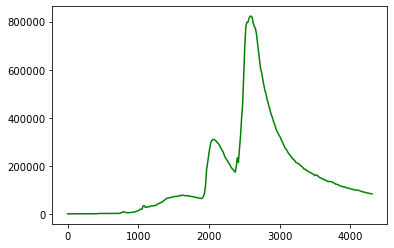

In [15]:
plt.plot(storm['Cummulative_Time'], storm['Runoff_15'], color = 'g')

In [16]:
#Sum every four rows (every 15 minutes) to get runoff volume per hour
cummulative_runoff = storm['Runoff_15']
N = 4
cr = cummulative_runoff.groupby(cummulative_runoff.index // N).sum()


In [17]:
#Calculate runoff velocity
#rainfall intensity/ hour
precipitation = storm['Precip']
precipitation = precipitation.apply(lambda x: float(x))
N = 4
rainfall_intensity = precipitation.groupby(precipitation.index // N).sum()
print(rainfall_intensity)

7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
     ... 
75    0.0
76    0.0
77    0.0
78    0.0
79    0.0
Name: Precip, Length: 73, dtype: float64


In [30]:
list_of_tuples = list(zip(rainfall_intensity, cr)) 
df = pd.DataFrame(list_of_tuples,
                  columns = ['Precipitation_per_hr', 'runoff_per_hr']) 

In [40]:
df.to_csv("C:/Users/Administrator/Desktop/788p/Natalie_project/Data/hourly.csv")

In [31]:
df['Precipitation_per_hr'] = df['Precipitation_per_hr'].apply(lambda x: float(x))


In [32]:
df

,Precipitation_per_hr,runoff_per_hr
0,0.0,720.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,360.0
...,...,...
68,0.0,395640.0
69,0.0,377640.0
70,0.0,357840.0
71,0.0,341640.0


In [33]:
df['Cummulative_Time']= np.arange(0, 73, 1)
df

,Precipitation_per_hr,runoff_per_hr,Cummulative_Time
0,0.0,720.0,0
1,0.0,0.0,1
2,0.0,0.0,2
3,0.0,0.0,3
4,0.0,360.0,4
...,...,...,...
68,0.0,395640.0,68
69,0.0,377640.0,69
70,0.0,357840.0,70
71,0.0,341640.0,71


In [37]:
df['cum_precip'] = df['Precipitation_per_hr'].cumsum()
df

,Precipitation_per_hr,runoff_per_hr,Cummulative_Time,cum_precip
0,0.0,720.0,0,0.00
1,0.0,0.0,1,0.00
2,0.0,0.0,2,0.00
3,0.0,0.0,3,0.00
4,0.0,360.0,4,0.00
...,...,...,...,...
68,0.0,395640.0,68,1.46
69,0.0,377640.0,69,1.46
70,0.0,357840.0,70,1.46
71,0.0,341640.0,71,1.46


Text(0, 0.5, 'Runoff Volume (cf)')

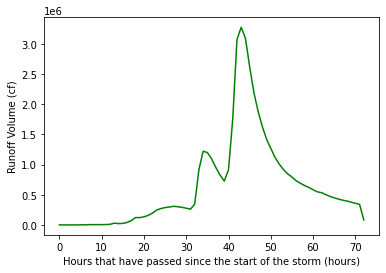

In [35]:
plt.plot(df['Cummulative_Time'], df['runoff_per_hr'], color = 'g')
plt.xlabel("Hours that have passed since the start of the storm (hours)")
plt.ylabel("Runoff Volume (cf)")

Text(0, 0.5, 'Cumulative Precipitation (inches)')

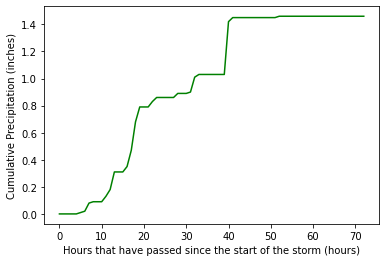

In [38]:
plt.plot(df['Cummulative_Time'], df['cum_precip'], color = 'g')
plt.xlabel("Hours that have passed since the start of the storm (hours)")
plt.ylabel("Cumulative Precipitation (inches)")

In [23]:
df.drop(['Precipitation_per_hr'],axis=1,inplace=True)
df

,runoff_per_hr,Cummulative_Time
0,720.0,0
1,0.0,1
2,0.0,2
3,0.0,3
4,360.0,4
...,...,...
68,395640.0,68
69,377640.0,69
70,357840.0,70
71,341640.0,71


In [24]:
log = df
log['runoff_per_hr'] = np.log10(log['runoff_per_hr'])
log

C:\Users\Administrator\anaconda3\envs\gds\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,runoff_per_hr,Cummulative_Time
0,2.857332,0
1,-inf,1
2,-inf,2
3,-inf,3
4,2.556303,4
...,...,...
68,5.597300,68
69,5.577078,69
70,5.553689,70
71,5.533569,71


Text(0, 0.5, 'Log of Runoff Volume (cf)')

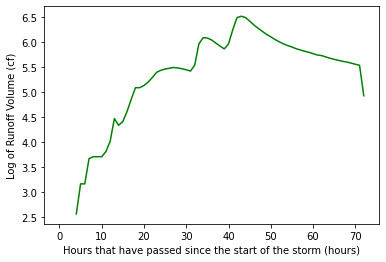

In [39]:
plt.plot(log['Cummulative_Time'], log['runoff_per_hr'], color = 'g')
plt.xlabel("Hours that have passed since the start of the storm (hours)")
plt.ylabel("Log of Runoff Volume (cf)")

In [25]:
df2 = df.T
df2

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
runoff_per_hr,2.857332,-inf,-inf,-inf,2.556303,3.158362,3.158362,3.661813,3.702431,3.702431,...,5.700565,5.674071,5.652865,5.631484,5.612826,5.5973,5.577078,5.553689,5.533569,4.922258
Cummulative_Time,0.000000,1.0,2.0,3.0,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,63.000000,64.000000,65.000000,66.000000,67.000000,68.0000,69.000000,70.000000,71.000000,72.000000


In [26]:
log2 = log.T
log2

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,72
runoff_per_hr,2.857332,-inf,-inf,-inf,2.556303,3.158362,3.158362,3.661813,3.702431,3.702431,...,5.700565,5.674071,5.652865,5.631484,5.612826,5.5973,5.577078,5.553689,5.533569,4.922258
Cummulative_Time,0.000000,1.0,2.0,3.0,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,63.000000,64.000000,65.000000,66.000000,67.000000,68.0000,69.000000,70.000000,71.000000,72.000000


In [27]:
#read in river shapefile
river = gpd.read_file("C:/Users/Administrator/Desktop/788p/Natalie_project/Data/River.shp")

In [28]:
print(river)

   OID_   Name FolderPath  SymbolID  AltMode  Base  Clamped  Extruded Snippet  \
0     0  River  River.kmz         0        0   0.0       -1         0    None   

  PopupInfo  Shape_Leng  Shape_Area  \
0      None    0.022488    0.000002   

                                            geometry  
0  POLYGON Z ((-78.13345 42.73818 0.00000, -78.13...  


In [30]:
#add in a common column to join
df2['SymbolID'] = 0
log2['SymbolID'] = 0

In [31]:
df2

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,SymbolID
runoff_per_hr,2.857332,-inf,-inf,-inf,2.556303,3.158362,3.158362,3.661813,3.702431,3.702431,...,5.674071,5.652865,5.631484,5.612826,5.5973,5.577078,5.553689,5.533569,4.922258,0
Cummulative_Time,0.000000,1.0,2.0,3.0,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,...,64.000000,65.000000,66.000000,67.000000,68.0000,69.000000,70.000000,71.000000,72.000000,0


In [32]:
log2.to_csv("C:/Users/Administrator/Desktop/788p/Natalie_project/Data/hourlylog.csv")

In [33]:
#join
Join = river.merge(df2, on="SymbolID")
Join

,OID_,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,...,63,64,65,66,67,68,69,70,71,72
0,0,River,River.kmz,0,0,0.0,-1,0,None,None,...,5.700565,5.674071,5.652865,5.631484,5.612826,5.5973,5.577078,5.553689,5.533569,4.922258
1,0,River,River.kmz,0,0,0.0,-1,0,None,None,...,63.000000,64.000000,65.000000,66.000000,67.000000,68.0000,69.000000,70.000000,71.000000,72.000000


In [34]:
logJoin = river.merge(log2, on="SymbolID")
logJoin

,OID_,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,...,63,64,65,66,67,68,69,70,71,72
0,0,River,River.kmz,0,0,0.0,-1,0,None,None,...,5.700565,5.674071,5.652865,5.631484,5.612826,5.5973,5.577078,5.553689,5.533569,4.922258
1,0,River,River.kmz,0,0,0.0,-1,0,None,None,...,63.000000,64.000000,65.000000,66.000000,67.000000,68.0000,69.000000,70.000000,71.000000,72.000000


In [35]:
ro = Join.drop(1).head()
ro

,OID_,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,...,63,64,65,66,67,68,69,70,71,72
0,0,River,River.kmz,0,0,0.0,-1,0,None,None,...,5.700565,5.674071,5.652865,5.631484,5.612826,5.5973,5.577078,5.553689,5.533569,4.922258


In [36]:
logro = logJoin.drop(1).head()
logro

,OID_,Name,FolderPath,SymbolID,AltMode,Base,Clamped,Extruded,Snippet,PopupInfo,...,63,64,65,66,67,68,69,70,71,72
0,0,River,River.kmz,0,0,0.0,-1,0,None,None,...,5.700565,5.674071,5.652865,5.631484,5.612826,5.5973,5.577078,5.553689,5.533569,4.922258


In [37]:
#set parameters of loop
output_path = 'C:/Users/Administrator/Desktop/788p/Natalie_project/Maps'

In [38]:
log_output_path = 'C:/Users/Administrator/Desktop/788p/Natalie_project/LogMaps'

In [39]:
i = 0

In [40]:
hours_passed = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72]

In [41]:
log_hours_passed = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72]

In [42]:
vmin, vmax = 0, 3500000

In [43]:
log_vmin, log_vmax = 0, 7

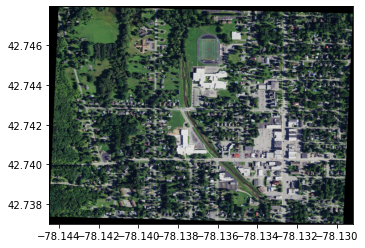

<AxesSubplot:>

In [44]:
#basemap
p = "C:/Users/Administrator/Desktop/788p/Natalie_project/Data/NAIP/NAIP_p.tif"
NAIP = rio.open(p)
show(NAIP)

In [ ]:
#create individual maps
for hour in hours_passed:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig = show(NAIP.read(), transform=NAIP.transform, ax=ax)
    fig = ro.plot(column=hour, ax=ax, cmap='YlGnBu', vmin=vmin, vmax=vmax, 
                       legend=True, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    
    fig.axis('off')
    
    fig.set_title('Runoff Volume from October 3rd- 5th', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    only_hour = str(hour) + ' hours passed'  
    ct = str(hour)
    
    fig.annotate(only_hour,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    filepath = os.path.join(output_path, str(ct)+'.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)

In [ ]:
for hour in log_hours_passed:
    
    fig, ax = plt.subplots(figsize=(10, 10))
    fig = show(NAIP.read(), transform=NAIP.transform, ax=ax)
    fig = logro.plot(column=hour, ax=ax, cmap='YlGnBu', vmin=log_vmin, vmax=log_vmax, 
                       legend=True, norm=plt.Normalize(vmin=log_vmin, vmax=log_vmax))
    
    fig.axis('off')
    
    fig.set_title('Log of Runoff Volume from October 3rd- 5th', \
              fontdict={'fontsize': '25',
                         'fontweight' : '3'})
    
    only_hour = str(hour) + ' hours passed'  
    ct = str(hour)
    
    fig.annotate(only_hour,
            xy=(0.1, .225), xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=35)
    
    filepath = os.path.join(log_output_path, str(ct)+'.png')
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=300)

C:\Users\ADMINI~1\AppData\Local\Temp\2/ipykernel_4588/2363968156.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 10))


In [38]:
#create gif
frames = []
imgs = glob.glob("C:/Users/Administrator/Desktop/788p/Natalie_project/Maps/*.png")
order = natsorted(imgs)

for i in order:
    new_frame = Image.open(i)
    frames.append(new_frame)
 

frames[0].save('C:/Users/Administrator/Desktop/788p/Natalie_project/gif/runoff_volume.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=350, loop=0)

In [3]:

frames = []
imgs = glob.glob("C:/Users/Administrator/Desktop/788p/Natalie_project/LogMaps/*.png")
order = natsorted(imgs)

for i in order:
    new_frame = Image.open(i)
    frames.append(new_frame)
 

frames[0].save('C:/Users/Administrator/Desktop/788p/Natalie_project/gif/log_runoff_volume.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=350, loop=0)